In [56]:
import numpy as np
import math as math
import scipy as sc
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import seaborn as sns
#import sklearn as sk

# Fáza 3
Autori: Jakub Smorada, Adrian Szacsko
Podiel práce: 50 % / 50 %

Na začiatku je potrebné načítať dáta, ktoré sme uložili na konci fázy 2.

In [57]:
test_dataset = pd.read_csv("faza2/test_dataset.csv", delimiter=",")
train_dataset = pd.read_csv("faza2/train_dataset.csv", delimiter=",")

test_dataset.drop(test_dataset.columns[0], axis=1, inplace=True)
train_dataset.drop(train_dataset.columns[0], axis=1, inplace=True)

Vyberieme len tie atribúty, ktoré majú najväčší vplyv na indikator.

In [58]:
train_attributes_dataset = train_dataset[['trombocyty','erytrocyty','alt','hematokrit','leukocyty', 'indicator']].copy()
test_attributes_dataset = test_dataset[['trombocyty','erytrocyty','alt','hematokrit','leukocyty', 'indicator']].copy()
train_attributes_dataset

,trombocyty,erytrocyty,alt,hematokrit,leukocyty,indicator
0,0.000000,0.657410,0.590051,0.124012,0.235670,0.0
1,0.472369,0.783140,0.756626,0.916138,0.979337,0.0
2,0.000000,0.758214,0.765718,0.618083,0.534911,0.0
3,0.520432,0.496035,0.358712,0.899930,0.451250,0.0
4,0.057209,0.578113,0.505168,0.612411,0.582834,0.0
...,...,...,...,...,...,...
7765,0.000000,0.928649,0.926709,0.605019,0.800762,0.0
7766,0.770651,0.490583,0.483083,0.462006,0.570330,1.0
7767,0.606216,0.793698,0.777088,0.000000,0.286733,1.0
7768,0.655724,0.680117,0.607614,0.065900,0.921863,1.0


## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

<AxesSubplot:xlabel='indicator', ylabel='trombocyty'>

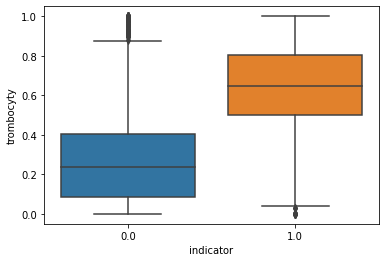

In [59]:
sns.boxplot(data=train_attributes_dataset, x="indicator", y="trombocyty")

In [60]:
from quick_sort import quickSort
from math import ceil

def oneR_model(dataset:pd.DataFrame, attribute):
    rows = len(dataset)
    percent = ceil(rows*0.3)
    min = 0
    max = 0
    zero_array = []
    one_array = []
    for i in range(rows):
        if dataset["indicator"][i] == 0:
            zero_array.append(dataset[attribute][i])
        else:
            one_array.append(dataset[attribute][i])

    quickSort(one_array, 0, len(one_array)-1)
    quickSort(zero_array, 0, len(zero_array)-1)
    zero_array = zero_array[::-1]

    if percent > len(one_array):
        percent = len(one_array)
    if percent > len(zero_array):
        percent = len(zero_array)

    for i in range(percent):
        min += one_array[i]
        max += zero_array[i]

    min = min/percent
    max = max/percent

    threshold = (min+max)/2
    return threshold


def oneR(model, dataset_attr):
    predict = []
    for i in dataset_attr:
        if i > model:
            predict.append(1)
        else:
            predict.append(0)
    return predict


Trombocyty, Erytrocyty, Alt, Hematokrit a Leukocyty

In [61]:
model = oneR_model(train_attributes_dataset, "trombocyty")
oneR_prediction = oneR(model, train_attributes_dataset["trombocyty"])

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def evaluation(output, prediction):
    print("Accuracy:",accuracy_score(output, prediction))
    print("Precision:",precision_score(output, prediction, average='macro'))
    print("Recall:",recall_score(output, prediction, average='macro'))

In [63]:
print("\nTrenovaci dataset:")
evaluation(train_attributes_dataset["indicator"], oneR_prediction)
oneR_prediction_test = oneR(model, test_attributes_dataset["trombocyty"])
print("\nTestovaci dataset:")
evaluation(test_attributes_dataset["indicator"], oneR_prediction_test)


Trenovaci dataset:
Accuracy: 0.8223938223938224
Precision: 0.8083146067415731
Recall: 0.8023544689740839

Testovaci dataset:
Accuracy: 0.8111168296448791
Precision: 0.7943753597467383
Recall: 0.7856402326214595


## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia


Rozdelíme datasety z trénovacej a testovacej na trénovací vstup, trénovací výstup, testovací vstup a testovací výstup
pre vyhodnotenie UI algoritmov

In [64]:
train_attributes_dataset_input = train_attributes_dataset.drop(columns=["indicator"])
train_attributes_dataset_output = train_attributes_dataset["indicator"].copy()

test_attributes_dataset_input = test_attributes_dataset.drop(columns=["indicator"])
test_attributes_dataset_output = test_attributes_dataset["indicator"].copy()


Vytvoríme model pre náš dataset podľa trénovacej množiny a vyzualizujeme natrénované pravidlá

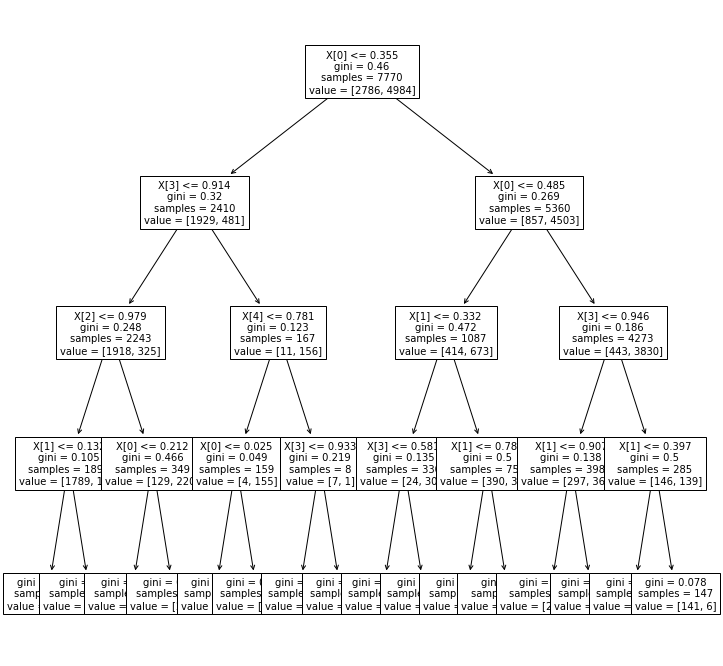

Tree model:


In [65]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier(max_depth=4)

tree_model = tree_model.fit(train_attributes_dataset_input, train_attributes_dataset_output)

plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(tree_model, fontsize=10)
plt.show()
#tree.plot_tree(tree_model)
print("Tree model:")

Pomocou vytvorenej tree_model predikujeme indikátor na trénovacej a na testovacej množine

In [66]:
tree_train_output = tree_model.predict(train_attributes_dataset_input)
print("Trenovaci dataset:")
evaluation(train_attributes_dataset_output, tree_train_output)
print("\nTestovaci dataset:")
tree_test_output = tree_model.predict(test_attributes_dataset_input)
evaluation(test_attributes_dataset_output, tree_test_output)

Trenovaci dataset:
Accuracy: 0.918018018018018
Precision: 0.9196141201558561
Recall: 0.9008747590278842

Testovaci dataset:
Accuracy: 0.9140504374678332
Precision: 0.9175938519625112
Recall: 0.8922589833632372


Vidíme, že náš tree_model vedel odhadnúť priemerne 92% hodnôt indikátoru podľa zadaných atribútov

Pri porovnaní nášho OneR predikciu s tree_model predikciou vidíme, že stromový algoritmus vyhodnotil priemerne o 10%
lepšie indikátor ako náš algoritmus. To je možné z dôvodu, že náš OneR algoritmus pracuje len s jedným atribútom, kým
stromový algoritmus s piatimi.

In [67]:
evaluation(test_attributes_dataset["indicator"], oneR_prediction_test)

Accuracy: 0.8111168296448791
Precision: 0.7943753597467383
Recall: 0.7856402326214595


In [68]:
def compare_accuracies(output, prediction1, prediction2):
    acc_1 = accuracy_score(output, prediction1)
    prec1 = precision_score(output, prediction1, average='macro')
    rec1 = recall_score(output, prediction1, average='macro')
    acc_2 = accuracy_score(output, prediction2)
    prec2 = precision_score(output, prediction2, average='macro')
    rec2 = recall_score(output, prediction2, average='macro')
    dataset = pd.DataFrame([[acc_1, prec1, rec1], [acc_2, prec2, rec2]], columns=["Accuracy", "Precision", "Recall"])
    return dataset

comparison = compare_accuracies(test_attributes_dataset["indicator"], oneR_prediction_test, tree_test_output)
comparison['Name'] = ["OneR", "Tree"]
comparison

,Accuracy,Precision,Recall,Name
0,0.811117,0.794375,0.785640,OneR
1,0.914050,0.917594,0.892259,Tree


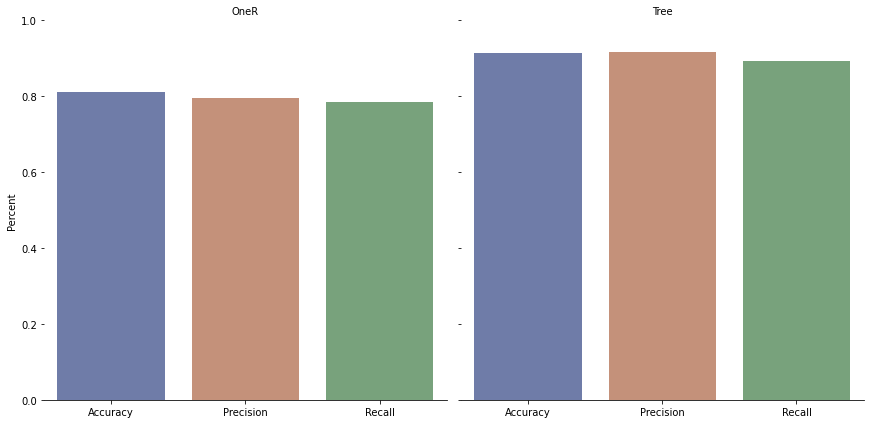

In [69]:
#sns.catplot(data=comparison,col="Name", kind="bar",ci="sd", palette="dark")
g=sns.catplot(data=comparison, col="Name", kind="bar", palette="dark", alpha=.6, height=6)
(g.set_axis_labels("", "Percent")
  .set_titles("{col_name}")
  .set(ylim=(0, 1))
  .despine(left=True))

## 3. Optimalizácia - hyperparameter tuning

Zvolme parametre pre tree_model, ktoré vyskúšame pomocou Grid Search Cross Validation

In [70]:
# Create the parameter grid based on the results of random search
params = {
    'max_depth': [2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

Aplikujme vybrané parametre na tree_model aj s použitím cross_validation s k=5

In [71]:
tree_model = tree.DecisionTreeClassifier()

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=tree_model,
                           param_grid=params,
                           cv=5,
                           scoring = "accuracy")

Nájdime najlepšie hyperparametre

In [72]:
grid_search.fit(train_attributes_dataset_input, train_attributes_dataset_output)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 15, 20],
                         'min_samples_leaf': [2, 5, 10, 20, 50, 100]},
             scoring='accuracy')

Vypíšme jednotlivé výsledky pomocou Dataframe

In [73]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007999,1.049042e-06,0.001400,0.000200,gini,2,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.848134,0.851995,0.835907,0.843629,0.841055,0.844144,0.005571,61
1,0.008398,2.003463e-04,0.001402,0.000374,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.848134,0.851995,0.835907,0.843629,0.841055,0.844144,0.005571,61
2,0.008099,2.010358e-04,0.001400,0.000200,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.848134,0.851995,0.835907,0.843629,0.841055,0.844144,0.005571,61
3,0.008200,2.449508e-04,0.001400,0.000200,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.848134,0.851995,0.835907,0.843629,0.841055,0.844144,0.005571,61
4,0.008000,8.449576e-07,0.001400,0.000200,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.848134,0.851995,0.835907,0.843629,0.841055,0.844144,0.005571,61


Nájdime najlepšie ohodnotenie pomocou sám vytvorenej funkcie, ktorá vyberie najlepšie ohodnotené výsledky a vypíše ich

In [74]:
def get_best_criterion(dataset):
    row : pd.DataFrame = score_df.loc[score_df['rank_test_score'] == 1]
    for column in row.columns:
        if "param_" in column:
            parameter = row[column].to_string().split(" ")
            print(column.split("param_")[1] + ": " + str(parameter[len(parameter)-1]))
    score = row["mean_test_score"].to_string().split(" ")
    print("Mean test score:", score[len(score)-1])



In [75]:
score_df.nlargest(5,"mean_test_score")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
55,0.043800,0.006919,0.001499,0.000002,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.938224,0.936293,0.940798,0.945946,0.938867,0.940026,0.003291,1
62,0.044700,0.001122,0.001800,0.000245,entropy,15,10,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.938224,0.932432,0.936937,0.945302,0.941441,0.938867,0.004326,2
56,0.039800,0.001289,0.001600,0.000200,entropy,10,10,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.938224,0.934363,0.938867,0.945302,0.937580,0.938867,0.003571,3
68,0.055900,0.007194,0.001802,0.000401,entropy,20,10,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.938224,0.930502,0.937580,0.945946,0.939511,0.938353,0.004924,4
19,0.027598,0.000969,0.001700,0.000245,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.933719,0.938224,0.940798,0.939511,0.934363,0.937323,0.002808,5


Zavolajme sám vvytvorenú funkciu get_best_criterion, aby sme dostali najlepšie ohodnotenie

In [76]:
get_best_criterion(score_df)

criterion: entropy
max_depth: 10
min_samples_leaf: 5
Mean test score: 0.940026


Môžeme vidieť, že najlepšie hodnotenie sme dostali použitím entropy s maximálnou hĺbkou 10 a s minimálnou hodnotou
listov 10

S týmto parametrami sme dostali správne výsledky so šancou 93%

Tree model:


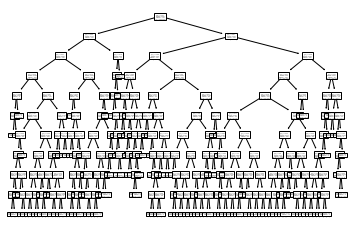

In [77]:
tree_model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=5)
tree_model = tree_model.fit(train_attributes_dataset_input, train_attributes_dataset_output)

tree.plot_tree(tree_model)
print("Tree model:")

Môžeme vidieť, že pri použití hyperparametre nám accuracy zvíšil na hodnotu 94.8%, kým sme použili aj menší strom ako
vyššie keď sme vytovrili model bez hyperparametrov

In [78]:
best_tree_model = grid_search.best_estimator_
predict_with_hyperparam = best_tree_model.predict(test_attributes_dataset_input)
evaluation(test_attributes_dataset_output, predict_with_hyperparam)

Accuracy: 0.9480185280494081
Precision: 0.9465610608903292
Recall: 0.9386890258801845


Vysvetlenie parametrov:

 - max_depth určuje maximálnu hĺbku vytvorenej stromy
 - min_samples_leaf zaručuje minimálny počet vzoriek v liste
 - entropy je formula použitá na rozdelenie listov s strome

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu


In [79]:
def create_dicts(column_name, dataset_final):
    dictionary = {}
    counter = 0
    for column_name in dataset_final[column_name].unique():
        dictionary[column_name] = counter
        counter += 1

    return dictionary

def change_values(dictionary, column_name, dataset_final):
     dataset_final[column_name].replace(dictionary, inplace=True)
     return dataset_final

In [85]:
def del_outliers(data, column):
    data_mean, data_std = np.mean(data), np.std(data)

    # define outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    #print('Počet vychýlených hodnôt v stĺpci ' + column + ': %d' % len(outliers))

    outliers_removed = []
    for x in data:
        if x >= lower and x <= upper:
            outliers_removed.append(x)
        else:
            outliers_removed.append(np.nan)
    # remove outliers
    #outliers_removed = [x for x in data if x >= lower and x <= upper else np.nan]
    return outliers_removed


In [83]:
def load_datasets():
    dataset = pd.read_csv("faza1/labor.csv", delimiter=",")
    dataprofiles = pd.read_csv("faza1/profiles.csv", delimiter=",")
    dataset.drop(dataset.columns[0], axis=1, inplace=True)
    dataprofiles.drop(dataprofiles.columns[0], axis=1, inplace=True)
    return dataset, dataprofiles


def to_numeric(dataset):
    relationship_dict = create_dicts("relationship", dataset)
    dataset = change_values(relationship_dict,"relationship", dataset)

    blood_group_dict = create_dicts("blood_group", dataset)
    dataset = change_values(blood_group_dict,"blood_group", dataset)

    sex_dict = create_dicts("sex", dataset)
    dataset = change_values(sex_dict, "sex", dataset)

    race_dict = create_dicts("race", dataset)
    dataset = change_values(race_dict,"race", dataset)
    return dataset


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

def transform(dataset):
    pipeline = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson', standardize=False,)),
    ('scaler', MinMaxScaler())
    ])
    new = pipeline.fit_transform(dataset)
    new = pd.DataFrame(new)
    new.columns = dataset.columns.copy()
    return new

dict_for_strategies = {
    1 : "del missing, del outliers, trans off",
    2 : "del missing, del outliers, trans on",
    3 : "del missing, outliers, trans off",
    4 : "del missing, outliers, trans on",
    5 : "missing, del outliers, trans off",
    6 : "missing, del outliers, trans on",
    7 : "missing, outliers, trans off",
    8 : "missing, outliers, trans on"
}
"""
1 -> del missing, del outliers, trans off
2 -> del missing, del outliers, trans on
3 -> del missing, outliers, trans off
4 -> del missing, outliers, trans on
5 -> missing, del outliers, trans off
6 -> missing, del outliers, trans on
7 -> missing, outliers, trans off
8 -> missing, outliers, trans on
"""

from sklearn.impute import SimpleImputer
from copy import deepcopy

def compare_strategies():
    dataset, dataprofiles = load_datasets()

    dataset_final = dataset.merge(dataprofiles, on="ssn", how = 'left')
    dataset_final.drop(columns=["name_y"], inplace=True)
    dataset_final.rename(columns={'name_x': 'name'}, inplace=True)

    strat_dataset = []
    for i in range(8):
        strat_dataset.append(deepcopy(to_numeric(dataset_final)))
        strat_dataset[i].drop(columns=['name','ssn','job','company','address','birthdate'], inplace=True)
        # run strategies -> missing
        if i+1 <= 4:  # delete missing
            strat_dataset[i].dropna(inplace=True)
        else:
            imp=SimpleImputer(missing_values=np.NaN, strategy='median')
            dataset_median=pd.DataFrame(imp.fit_transform(strat_dataset[i]))
            dataset_median.columns=strat_dataset[i].columns
            dataset_median.index=strat_dataset[i].index
            strat_dataset[i] = dataset_median.copy()

        # run strategies -> outliers
        if (i+1) % 4 <= 1 or (i+1) % 4 <= 2: # delete outliers
            for col in dataset.describe().columns:
                if col != 'smoker' and col != 'weight':
                    strat_dataset[i][col] = del_outliers(strat_dataset[i][col], col)
            strat_dataset[i].dropna(inplace=True)
        else:
            for col in dataset.describe().columns:
                if col != 'smoker' and col != 'weight':
                    strat_dataset[i][col] = sc.stats.mstats.winsorize(strat_dataset[i][col], limits=[0.05,0.05])

        # run strategies -> transform
        if (i+1) % 2 == 1: # do transform
            strat_dataset[i] = transform(strat_dataset[i])

        strat_dataset[i] = strat_dataset[i][['trombocyty','erytrocyty','alt','hematokrit','leukocyty', 'indicator']].copy()

    return strat_dataset

In [86]:
strategy_datasets = compare_strategies()

In [ ]:
from sklearn.model_selection import train_test_split

def create_train_test(dataset):
    train, test = train_test_split(dataset, test_size=0.2, shuffle=True)
    return train, test

In [ ]:
train_input = []
train_output = []
test_input = []
test_output = []

for i in range(len(strategy_datasets)):
    train_input.append([])
    train_output.append([])
    test_input.append([])
    test_output.append([])
    train[i], test[i] = train_test_split(strategy_datasets[i], test_size=0.2, shuffle=True)


In [ ]:
for i in range(len(strategy_datasets)):
    grid_search.fit(train[i], test[i])